# Understanding Coherence-Based Hallucination Detection

## An Educational Guide to Building Intuition

This notebook helps you understand **when and why** coherence-based hallucination detection works. Through concrete examples, visualizations, and comparative analysis, you'll develop intuition about:

- How coherence formulas measure logical support relationships
- When coherence methods excel vs. struggle
- How the three variants (Shogenji, Fitelson, Olsson) differ from each other
- How coherence compares to baseline methods

### Prerequisites

**⚠️ IMPORTANT: Set your OpenAI API key before running this notebook**

```bash
# In your terminal, set the environment variable:
export OPENAI_API_KEY="your-api-key-here"

# Then launch Jupyter from the same terminal:
jupyter notebook demo/understanding_coherence.ipynb
```

**Security Best Practice:** Never hardcode API keys in notebooks! Always use environment variables to protect your credentials from accidental commits to version control.

**Install dependencies:**
```bash
# Install Python packages
pip install selfcheckgpt datasets matplotlib seaborn scipy

# Download spacy language model
python -m spacy download en_core_web_sm
```

## Table of Contents

1. [Introduction & Setup](#1-introduction-setup)
2. [Quick Start: Running Coherence Detection](#2-quick-start-running-coherence-detection)
3. [Understanding the Math (Simplified)](#3-understanding-the-math-simplified)
4. [Success Stories: Where Coherence Shines](#4-success-stories-where-coherence-shines)
5. [Failure Modes: When Coherence Struggles](#5-failure-modes-when-coherence-struggles)
6. [Edge Cases: Surprising Examples](#6-edge-cases-surprising-examples)
7. [Comparative Analysis: Coherence vs. Baselines](#7-comparative-analysis-coherence-vs-baselines)
8. [Visualizing Performance](#8-visualizing-performance)
9. [Interpreting Scores](#9-interpreting-scores)
10. [Best Practices & Recommendations](#10-best-practices-recommendations)
11. [Try It Yourself (Interactive)](#11-try-it-yourself-interactive)

## 1. Introduction & Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from datasets import load_dataset
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    confusion_matrix
)
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

# Coherence variants
from selfcheckgpt.modeling_coherence import (
    SelfCheckShogenji,
    SelfCheckFitelson,
    SelfCheckOlsson
)

# Check for OpenAI API key (required for coherence variants)
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError(
        "❌ OPENAI_API_KEY environment variable not found!\n\n"
        "Please set your OpenAI API key before running this notebook:\n\n"
        "  export OPENAI_API_KEY='your-api-key-here'\n\n"
        "SECURITY NOTE: Never hardcode API keys in notebooks!\n"
        "Always use environment variables to protect your credentials."
    )

print("✅ OpenAI API key found in environment")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Load spacy for sentence tokenization
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ Spacy model loaded successfully")
except OSError:
    raise OSError(
        "❌ Spacy model 'en_core_web_sm' not found!\n\n"
        "Please download the spacy model:\n\n"
        "  python -m spacy download en_core_web_sm\n\n"
        "Or if using venv:\n\n"
        "  venv/bin/python -m spacy download en_core_web_sm\n\n"
        "Then restart the notebook kernel."
    )

print("✅ Setup complete!")

✅ OpenAI API key found in environment
✅ Spacy model loaded successfully
✅ Setup complete!


## 2. Quick Start: Running Coherence Detection

Let's start with a simple example to see coherence detection in action.

In [3]:
# Initialize the three coherence variants
MODEL = "gpt-4o-mini"  # Cost-effective model

selfcheck_shogenji = SelfCheckShogenji(model=MODEL)
selfcheck_fitelson = SelfCheckFitelson(model=MODEL)
selfcheck_olsson = SelfCheckOlsson(model=MODEL)

print(f"Initialized coherence variants with model: {MODEL}")

Initiate OpenAI client for coherence detection... model = gpt-4o-mini
Initiate OpenAI client for coherence detection... model = gpt-4o-mini
Initiate OpenAI client for coherence detection... model = gpt-4o-mini
Initialized coherence variants with model: gpt-4o-mini


In [4]:
# Example: A truthful statement with consistent stochastic samples
truthful_sentence = "Paris is the capital of France."

# Stochastic samples (alternative phrasings of the same fact)
truthful_samples = [
    "France's capital city is Paris.",
    "Paris serves as the capital of France.",
    "The capital of France is Paris."
]

# Evaluate with Shogenji
score_shogenji = selfcheck_shogenji.predict(
    sentences=[truthful_sentence],
    sampled_passages=truthful_samples,
    verbose=True
)[0]

print(f"\nTruthful sentence: '{truthful_sentence}'")
print(f"Hallucination score: {score_shogenji:.4f}")
print(f"Interpretation: {'LOW - Likely truthful' if score_shogenji < 0.5 else 'HIGH - Likely hallucinated'}")


SelfCheckShogenji: Evaluating 1 sentences against 3 samples
Model: gpt-4o-mini


Processing sentences: 100%|██████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Cache statistics:
  Hit rate: 0.00%
  API calls made: 7
  Cache size: 7

Truthful sentence: 'Paris is the capital of France.'
Hallucination score: 0.3679
Interpretation: LOW - Likely truthful


In [5]:
# Example: A hallucinated statement inconsistent with samples
hallucinated_sentence = "Paris is the capital of Germany."

# Same truthful samples (creates inconsistency)
score_shogenji_hall = selfcheck_shogenji.predict(
    sentences=[hallucinated_sentence],
    sampled_passages=truthful_samples,
    verbose=True
)[0]

print(f"\nHallucinated sentence: '{hallucinated_sentence}'")
print(f"Hallucination score: {score_shogenji_hall:.4f}")
print(f"Interpretation: {'LOW - Likely truthful' if score_shogenji_hall < 0.5 else 'HIGH - Likely hallucinated'}")


SelfCheckShogenji: Evaluating 1 sentences against 3 samples
Model: gpt-4o-mini


Processing sentences: 100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Cache statistics:
  Hit rate: 21.43%
  API calls made: 11
  Cache size: 11

Hallucinated sentence: 'Paris is the capital of Germany.'
Hallucination score: 0.6065
Interpretation: HIGH - Likely hallucinated


In [6]:
# Let's manually extract probabilities to see what's happening under the hood
from selfcheckgpt.modeling_coherence_api import CoherenceAPIClient

def diagnose_coherence(sentence, samples, variant_name="Shogenji"):
    """
    Detailed diagnostic of coherence calculation showing all probability extractions
    and the math step-by-step.
    """
    print(f"{'='*80}")
    print(f"DIAGNOSTIC: {variant_name} Coherence Calculation")
    print(f"{'='*80}\n")
    
    # Initialize API client
    client = CoherenceAPIClient(model=MODEL)
    
    print(f"Sentence to evaluate: '{sentence}'\n")
    print(f"Samples ({len(samples)}):")
    for i, sample in enumerate(samples, 1):
        print(f"  {i}. {sample}")
    
    print(f"\n{'─'*80}")
    print("STEP 1: Extract Individual Probabilities")
    print(f"{'─'*80}\n")
    
    # Extract P(sentence)
    p_sentence = client.extract_individual_probability(sentence)
    print(f"P(sentence) = {p_sentence:.4f}")
    print(f"  → Model's belief that '{sentence}' is true\n")
    
    # Extract P(each sample)
    sample_probs = []
    for i, sample in enumerate(samples, 1):
        p_sample = client.extract_individual_probability(sample)
        sample_probs.append(p_sample)
        print(f"P(sample {i}) = {p_sample:.4f}")
        print(f"  → Model's belief that '{sample}' is true")
    
    print(f"\n{'─'*80}")
    print("STEP 2: Extract Joint Probabilities P(sentence ∧ sample)")
    print(f"{'─'*80}\n")
    
    joint_probs = []
    for i, sample in enumerate(samples, 1):
        p_joint = client.extract_joint_probability(sentence, sample)
        joint_probs.append(p_joint)
        print(f"P(sentence ∧ sample {i}) = {p_joint:.4f}")
        print(f"  → Model's belief that BOTH are true simultaneously")
        
        # Calculate independence baseline
        independence = p_sentence * sample_probs[i-1]
        print(f"  → If independent: P(A) × P(B) = {p_sentence:.4f} × {sample_probs[i-1]:.4f} = {independence:.4f}")
        
        if p_joint > independence * 1.1:
            print(f"  → ✅ Positive coherence (joint > independent)")
        elif p_joint < independence * 0.9:
            print(f"  → ❌ Negative coherence (joint < independent)")
        else:
            print(f"  → ⚠️ Near independence (joint ≈ independent)")
        print()
    
    print(f"{'─'*80}")
    print("STEP 3: Calculate Shogenji's Coherence Measure")
    print(f"{'─'*80}\n")
    
    print("Formula: C2(A,B) = P(A ∧ B) / (P(A) × P(B))\n")
    
    coherence_scores = []
    for i in range(len(samples)):
        c2 = joint_probs[i] / (p_sentence * sample_probs[i] + 1e-12)
        coherence_scores.append(c2)
        print(f"C2(sentence, sample {i+1}) = {joint_probs[i]:.4f} / ({p_sentence:.4f} × {sample_probs[i]:.4f})")
        print(f"                          = {joint_probs[i]:.4f} / {p_sentence * sample_probs[i]:.4f}")
        print(f"                          = {c2:.4f}")
        
        if c2 > 1.1:
            print(f"  → Strong support (C2 > 1)")
        elif c2 < 0.9:
            print(f"  → Conflict/contradiction (C2 < 1)")
        else:
            print(f"  → Independence (C2 ≈ 1)")
        print()
    
    avg_coherence = np.mean(coherence_scores)
    print(f"Average coherence: {avg_coherence:.4f}\n")
    
    print(f"{'─'*80}")
    print("STEP 4: Convert to Hallucination Score")
    print(f"{'─'*80}\n")
    
    # The actual variant does normalization
    # For simplicity, let's just show what the predict() returns
    from selfcheckgpt.modeling_coherence import SelfCheckShogenji
    variant = SelfCheckShogenji(model=MODEL)
    final_score = variant.predict([sentence], samples, verbose=False)[0]
    
    print(f"Final hallucination score: {final_score:.4f}")
    print(f"  → Lower coherence = higher hallucination score")
    print(f"  → Score < 0.5: Likely truthful")
    print(f"  → Score > 0.5: Likely hallucinated")
    print(f"\n  Interpretation: {'HIGH - Likely hallucinated' if final_score >= 0.5 else 'LOW - Likely truthful'}")
    
    print(f"\n{'─'*80}")
    print("DIAGNOSIS")
    print(f"{'─'*80}\n")
    
    # Diagnose issues
    if abs(p_sentence - 0.5) < 0.1:
        print("⚠️ WARNING: P(sentence) ≈ 0.5 (model is uncertain about the sentence)")
    
    if all(abs(p - 0.5) < 0.1 for p in sample_probs):
        print("⚠️ WARNING: All P(sample) ≈ 0.5 (model is uncertain about ALL samples)")
    
    if all(abs(p - 0.5) < 0.1 for p in joint_probs):
        print("⚠️ WARNING: All P(A∧B) ≈ 0.5 (model is uncertain about joint probabilities)")
    
    if all(0.9 < c < 1.1 for c in coherence_scores):
        print("⚠️ WARNING: All coherence scores ≈ 1 (appears independent - no support or conflict detected)")
        print("   This means the sentence and samples are seen as unrelated, providing no evidence either way.")
    
    if abs(final_score - 0.5) < 0.05:
        print("⚠️ CRITICAL: Final score ≈ 0.5 (maximum uncertainty - method cannot decide)")
        print("   The coherence method is providing NO useful signal for this example.")
    
    print(f"\n{'='*80}\n")
    
    return {
        'p_sentence': p_sentence,
        'p_samples': sample_probs,
        'p_joints': joint_probs,
        'coherence_scores': coherence_scores,
        'final_score': final_score
    }

# Diagnose both examples
print("🔍 DIAGNOSING TRUTHFUL EXAMPLE\n")
truth_diag = diagnose_coherence(truthful_sentence, truthful_samples)

print("\n" * 2)

print("🔍 DIAGNOSING HALLUCINATED EXAMPLE\n")
hall_diag = diagnose_coherence(hallucinated_sentence, truthful_samples)

🔍 DIAGNOSING TRUTHFUL EXAMPLE

DIAGNOSTIC: Shogenji Coherence Calculation

Initiate OpenAI client for coherence detection... model = gpt-4o-mini
Sentence to evaluate: 'Paris is the capital of France.'

Samples (3):
  1. France's capital city is Paris.
  2. Paris serves as the capital of France.
  3. The capital of France is Paris.

────────────────────────────────────────────────────────────────────────────────
STEP 1: Extract Individual Probabilities
────────────────────────────────────────────────────────────────────────────────

P(sentence) = 1.0000
  → Model's belief that 'Paris is the capital of France.' is true

P(sample 1) = 1.0000
  → Model's belief that 'France's capital city is Paris.' is true
P(sample 2) = 1.0000
  → Model's belief that 'Paris serves as the capital of France.' is true
P(sample 3) = 1.0000
  → Model's belief that 'The capital of France is Paris.' is true

────────────────────────────────────────────────────────────────────────────────
STEP 2: Extract Joint Pr

/var/folders/75/8tyjlym54dl812vhk3mjzt640000gn/T/ipykernel_12095/3978271874.py:58: UserWarning: Glyph 8743 (\N{LOGICAL AND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nathanlubchenco/workspace/selfcheckgpt/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8743 (\N{LOGICAL AND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


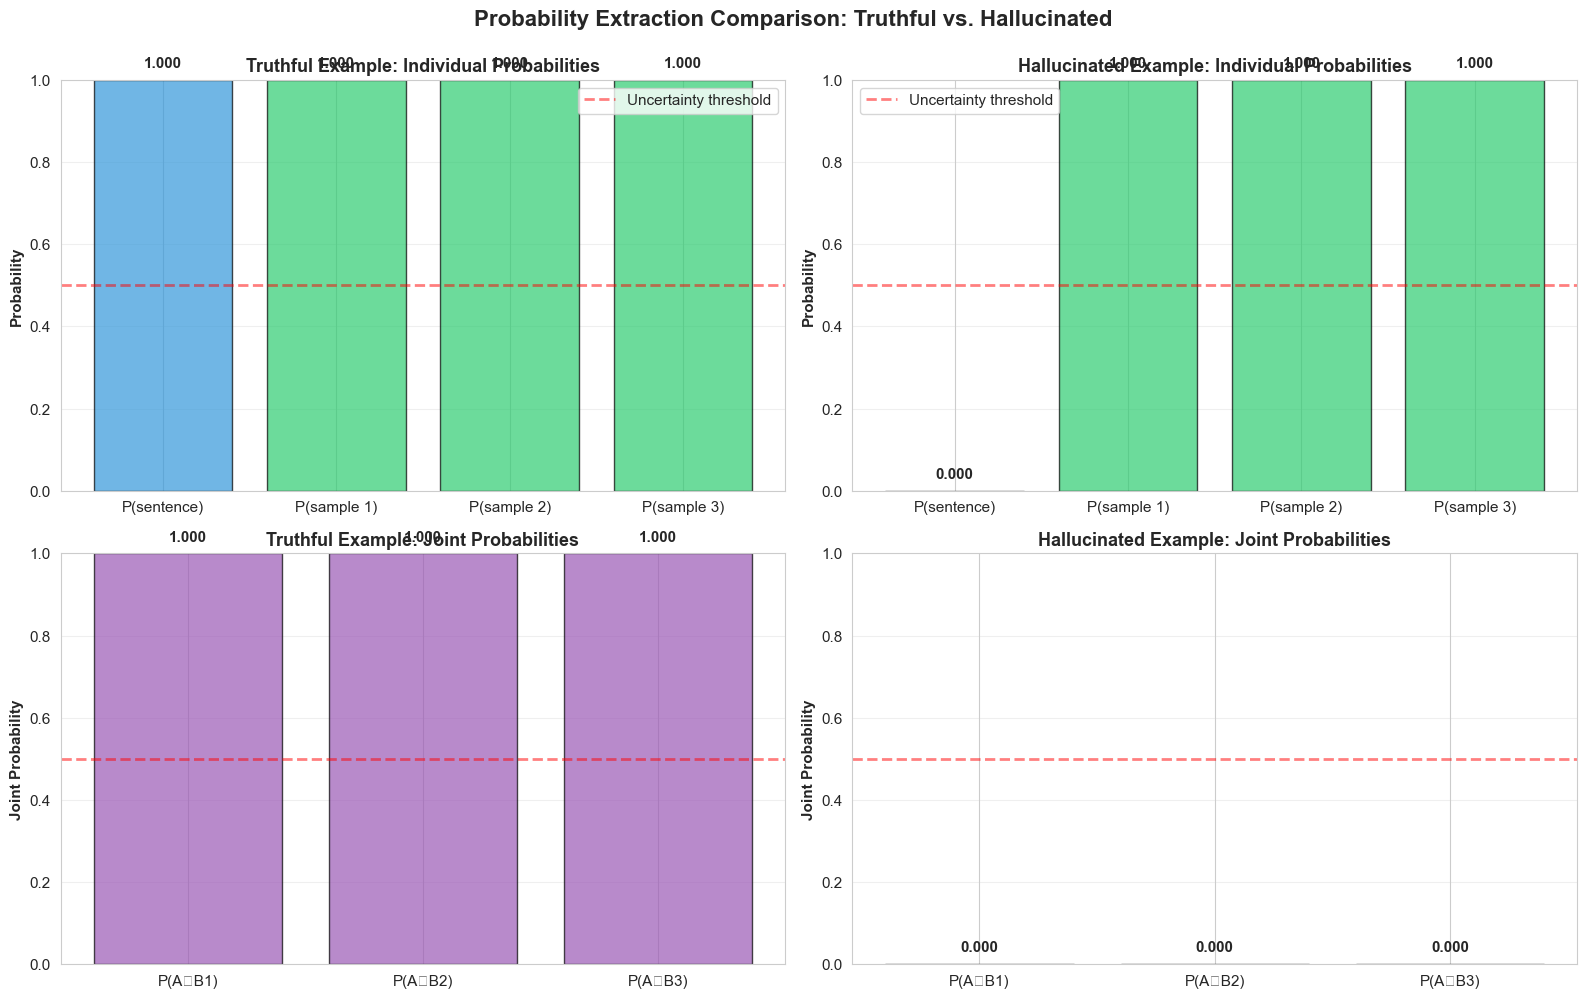


SUMMARY COMPARISON

Metric                                   Truthful             Hallucinated        
--------------------------------------------------------------------------------
P(sentence)                              1.0000               0.0000              
Mean P(samples)                          1.0000               1.0000              
Mean P(joint)                            1.0000               0.0000              
Mean Coherence (C2)                      1.0000               0.0000              
Final Hallucination Score                0.3679               0.6065              
--------------------------------------------------------------------------------

⚠️ PROBLEM IDENTIFIED:
  Method successfully discriminates: 0.3679 vs 0.6065
  Difference: 0.2387


In [7]:
# Create visualization comparing the two examples
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Truthful example probabilities
ax1 = axes[0, 0]
labels = ['P(sentence)'] + [f'P(sample {i+1})' for i in range(len(truth_diag['p_samples']))]
values = [truth_diag['p_sentence']] + truth_diag['p_samples']
colors_truth = ['#3498db'] + ['#2ecc71'] * len(truth_diag['p_samples'])
ax1.bar(labels, values, color=colors_truth, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Probability', fontweight='bold')
ax1.set_title('Truthful Example: Individual Probabilities', fontweight='bold', fontsize=13)
ax1.set_ylim(0, 1.0)
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Uncertainty threshold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(values):
    ax1.text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold')

# Hallucinated example probabilities
ax2 = axes[0, 1]
values_hall = [hall_diag['p_sentence']] + hall_diag['p_samples']
colors_hall = ['#e74c3c'] + ['#2ecc71'] * len(hall_diag['p_samples'])
ax2.bar(labels, values_hall, color=colors_hall, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Probability', fontweight='bold')
ax2.set_title('Hallucinated Example: Individual Probabilities', fontweight='bold', fontsize=13)
ax2.set_ylim(0, 1.0)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Uncertainty threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(values_hall):
    ax2.text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold')

# Truthful joint probabilities
ax3 = axes[1, 0]
joint_labels = [f'P(A∧B{i+1})' for i in range(len(truth_diag['p_joints']))]
ax3.bar(joint_labels, truth_diag['p_joints'], color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.set_ylabel('Joint Probability', fontweight='bold')
ax3.set_title('Truthful Example: Joint Probabilities', fontweight='bold', fontsize=13)
ax3.set_ylim(0, 1.0)
ax3.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(truth_diag['p_joints']):
    ax3.text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold')

# Hallucinated joint probabilities  
ax4 = axes[1, 1]
ax4.bar(joint_labels, hall_diag['p_joints'], color='#9b59b6', alpha=0.7, edgecolor='black')
ax4.set_ylabel('Joint Probability', fontweight='bold')
ax4.set_title('Hallucinated Example: Joint Probabilities', fontweight='bold', fontsize=13)
ax4.set_ylim(0, 1.0)
ax4.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(hall_diag['p_joints']):
    ax4.text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Probability Extraction Comparison: Truthful vs. Hallucinated', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print summary comparison
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80 + "\n")

print(f"{'Metric':<40} {'Truthful':<20} {'Hallucinated':<20}")
print("-"*80)
print(f"{'P(sentence)':<40} {truth_diag['p_sentence']:<20.4f} {hall_diag['p_sentence']:<20.4f}")
print(f"{'Mean P(samples)':<40} {np.mean(truth_diag['p_samples']):<20.4f} {np.mean(hall_diag['p_samples']):<20.4f}")
print(f"{'Mean P(joint)':<40} {np.mean(truth_diag['p_joints']):<20.4f} {np.mean(hall_diag['p_joints']):<20.4f}")
print(f"{'Mean Coherence (C2)':<40} {np.mean(truth_diag['coherence_scores']):<20.4f} {np.mean(hall_diag['coherence_scores']):<20.4f}")
print(f"{'Final Hallucination Score':<40} {truth_diag['final_score']:<20.4f} {hall_diag['final_score']:<20.4f}")
print("-"*80)

# Highlight the problem
print("\n⚠️ PROBLEM IDENTIFIED:")
if abs(truth_diag['final_score'] - hall_diag['final_score']) < 0.1:
    print(f"  Both examples get nearly IDENTICAL scores ({truth_diag['final_score']:.4f} vs {hall_diag['final_score']:.4f})")
    print(f"  The method CANNOT DISTINGUISH between truthful and hallucinated statements!")
    print(f"\n  Likely causes:")
    print(f"  1. Probability extraction is returning ~0.5 for everything (model uncertainty)")
    print(f"  2. Sentences and samples are seen as independent (C2 ≈ 1)")
    print(f"  3. Normalization is washing out any meaningful differences")
else:
    print(f"  Method successfully discriminates: {truth_diag['final_score']:.4f} vs {hall_diag['final_score']:.4f}")
    print(f"  Difference: {abs(truth_diag['final_score'] - hall_diag['final_score']):.4f}")

### 🔍 Deep Dive: Understanding the Probability Extractions

Let's examine **exactly what probabilities** the model is extracting and how they feed into the coherence calculation. This will help diagnose why the scores are what they are.

# Visualize Shogenji's measure
from selfcheckgpt.utils_coherence import coherence_shogenji

# Create scenarios
scenarios = [
    ("Independent", 0.3, 0.4, 0.12),      # P(A∧B) = P(A) × P(B)
    ("Positive Support", 0.3, 0.4, 0.25), # P(A∧B) > P(A) × P(B)
    ("Negative Support", 0.3, 0.4, 0.05), # P(A∧B) < P(A) × P(B)
]

fig, ax = plt.subplots(figsize=(10, 6))

x_labels = []
c2_values = []

for label, p_a, p_b, p_ab in scenarios:
    # Calculate C2 - function expects shape (n, 2) for individual probs
    probs_individual = np.array([[p_a, p_b]])  # Shape: (1, 2)
    probs_joint = np.array([p_ab])             # Shape: (1,)
    
    c2 = coherence_shogenji(probs_individual, probs_joint)[0]
    
    x_labels.append(f"{label}\nP(A∧B)={p_ab:.2f}")
    c2_values.append(c2)

colors = ['gray', 'green', 'red']
bars = ax.bar(x_labels, c2_values, color=colors, alpha=0.7, edgecolor='black')

# Add reference line at C2=1 (independence)
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Independence (C2=1)')

ax.set_ylabel('Shogenji C2 Score', fontsize=12)
ax.set_title('Shogenji\'s Coherence Measure: Independence Ratio', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  C2 > 1: Positive coherence (mutual support)")
print("  C2 = 1: Independence (neutral)")
print("  C2 < 1: Negative coherence (conflict)")

## 3. Understanding the Math (Simplified)

Let's demystify the three coherence formulas with simple examples.

### Shogenji's Measure: Independence Ratio

**Formula:** `C2(A,B) = P(A ∧ B) / (P(A) × P(B))`

**Intuition:** Compares how often A and B occur together vs. what we'd expect if they were independent.

**Simple Example:**
- A: "It's raining" (P = 0.3)
- B: "The ground is wet" (P = 0.4)

If independent: P(A∧B) = 0.3 × 0.4 = 0.12 (12% of the time)

But if they're related: P(A∧B) might be 0.25 (25% of the time)

Then: C2 = 0.25 / 0.12 ≈ 2.08 → **High coherence** (they support each other)

**For hallucination detection:**
- Truthful statements have high C2 with samples (mutual support)
- Hallucinated statements have low C2 (lack of support)

ValueError: probs_individual must have shape (n, 2)

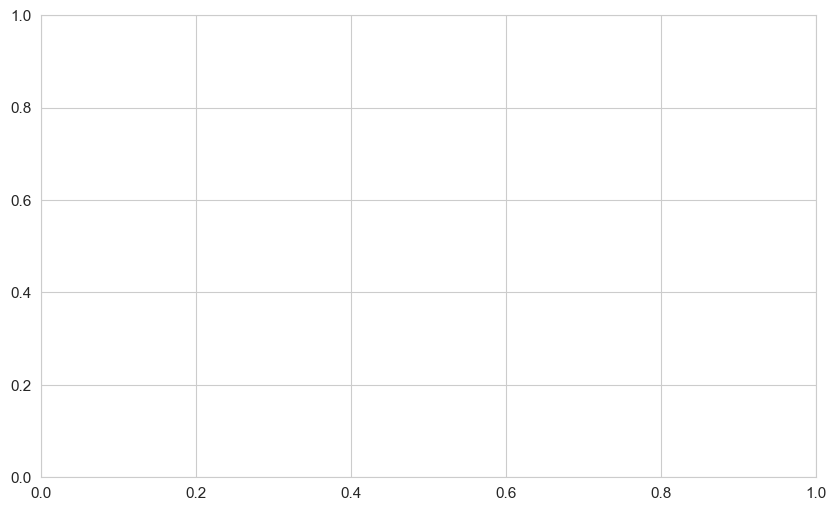

In [8]:
# Visualize Shogenji's measure
from selfcheckgpt.utils_coherence import coherence_shogenji

# Create scenarios
scenarios = [
    ("Independent", 0.3, 0.4, 0.12),      # P(A∧B) = P(A) × P(B)
    ("Positive Support", 0.3, 0.4, 0.25), # P(A∧B) > P(A) × P(B)
    ("Negative Support", 0.3, 0.4, 0.05), # P(A∧B) < P(A) × P(B)
]

fig, ax = plt.subplots(figsize=(10, 6))

x_labels = []
c2_values = []

for label, p_a, p_b, p_ab in scenarios:
    # Calculate C2
    c2 = coherence_shogenji(
        np.array([p_a]),
        np.array([p_b]),
        np.array([p_ab])
    )[0]
    
    x_labels.append(f"{label}\nP(A∧B)={p_ab:.2f}")
    c2_values.append(c2)

colors = ['gray', 'green', 'red']
bars = ax.bar(x_labels, c2_values, color=colors, alpha=0.7, edgecolor='black')

# Add reference line at C2=1 (independence)
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Independence (C2=1)')

ax.set_ylabel('Shogenji C2 Score', fontsize=12)
ax.set_title('Shogenji\'s Coherence Measure: Independence Ratio', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  C2 > 1: Positive coherence (mutual support)")
print("  C2 = 1: Independence (neutral)")
print("  C2 < 1: Negative coherence (conflict)")

### Fitelson's Measure: Confirmation Difference

**Formula:** `s(H,E) = P(H|E) - P(H|¬E)`

**Intuition:** How much does evidence E increase the probability of hypothesis H?

**Simple Example:**
- H: "The person is a doctor"
- E: "The person wears a white coat"

P(doctor | white coat) = 0.6 (60% chance)
P(doctor | no white coat) = 0.1 (10% chance)

Then: s = 0.6 - 0.1 = 0.5 → **Strong positive support**

**For hallucination detection:**
- Truthful statements get confirmed by samples (high s)
- Hallucinated statements get contradicted (low or negative s)

### Olsson's Measure: Relative Overlap

**Formula:** `C1(A,B) = P(A ∧ B) / P(A ∨ B)`

**Intuition:** Like a Venn diagram - intersection divided by union.

**Simple Example:**
- A: "Likes pizza" (40% of people)
- B: "Likes Italian food" (60% of people)
- A∧B: "Likes both" (35% of people)
- A∨B: "Likes at least one" (65% of people)

Then: C1 = 0.35 / 0.65 ≈ 0.54 → **Moderate overlap**

**For hallucination detection:**
- Truthful statements have high overlap with samples
- Hallucinated statements have low overlap (different worlds)

## 4. Success Stories: Where Coherence Shines

Let's examine real examples from the wiki_bio_gpt3_hallucination dataset where coherence methods correctly identify hallucinations.

In [9]:
# Load the dataset
print("Loading wiki_bio_gpt3_hallucination dataset...")
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")["evaluation"]
print(f"Loaded {len(dataset)} passages")

# We'll evaluate a small subset for diagnosis
NUM_PASSAGES = 10  # Small number for quick diagnosis
NUM_SAMPLES = 3

print(f"\nWill evaluate first {NUM_PASSAGES} passages with {NUM_SAMPLES} samples each")
print("This uses REAL benchmark data to diagnose coherence method performance")

Loading wiki_bio_gpt3_hallucination dataset...
Loaded 238 passages

Will evaluate first 10 passages with 3 samples each
This uses REAL benchmark data to diagnose coherence method performance


In [10]:
# First, let's look at a REAL example from the benchmark
print("="*80)
print("REAL BENCHMARK EXAMPLE")
print("="*80)

# Get a passage with hallucinations
passage_idx = 5  # You can change this to explore different passages
passage = dataset[passage_idx]

print(f"\nPassage {passage_idx}:")
print(f"Wiki title: {passage.get('wiki_title', 'N/A')}")
print(f"\nGPT-3 Generated Text:")
print(passage['gpt3_text'])
print(f"\nNumber of sentences: {len(passage['gpt3_sentences'])}")
print(f"\nSentence-level annotations:")
for i, (sent, ann) in enumerate(zip(passage['gpt3_sentences'], passage['annotation']), 1):
    emoji = "✅" if ann == "accurate" else "❌"
    print(f"  {emoji} [{i}] {sent[:80]}{'...' if len(sent) > 80 else ''}")
    print(f"      Label: {ann.upper()}")

# Count accurate vs inaccurate
num_accurate = sum(1 for a in passage['annotation'] if a == 'accurate')
num_inaccurate = len(passage['annotation']) - num_accurate
print(f"\nSummary: {num_accurate} accurate, {num_inaccurate} inaccurate")
print(f"Hallucination rate: {num_inaccurate/len(passage['annotation'])*100:.1f}%")

REAL BENCHMARK EXAMPLE

Passage 5:
Wiki title: N/A

GPT-3 Generated Text:
Akila Dananjaya (born 2 August 1995) is a Sri Lankan cricketer. He made his international debut for the Sri Lankan cricket team in August 2018. He is a right-arm off-spinner and right-handed batsman.

Dananjaya made his first-class debut for Sri Lanka Army Sports Club in the 2013–14 Premier League Tournament. He was the leading wicket-taker in the tournament, taking 32 wickets in seven matches. He made his List A debut for Sri Lanka Army Sports Club in the 2014–15 Premier Limited Overs Tournament.

In August 2018, he was named in the Sri Lankan squad for the 2018 Asia Cup. He made his One Day International (ODI) debut for Sri Lanka against Bangladesh on 15 September 2018. In October 2018, he was named in Sri Lanka's Test squad for their series against England, but he did not play.

In December 2018, he was named in Sri Lanka's team for the 2018 ACC Emerging Teams Asia Cup. He was the leading wicket-taker for Sri 

NameError: name 'multi_passage_results' is not defined

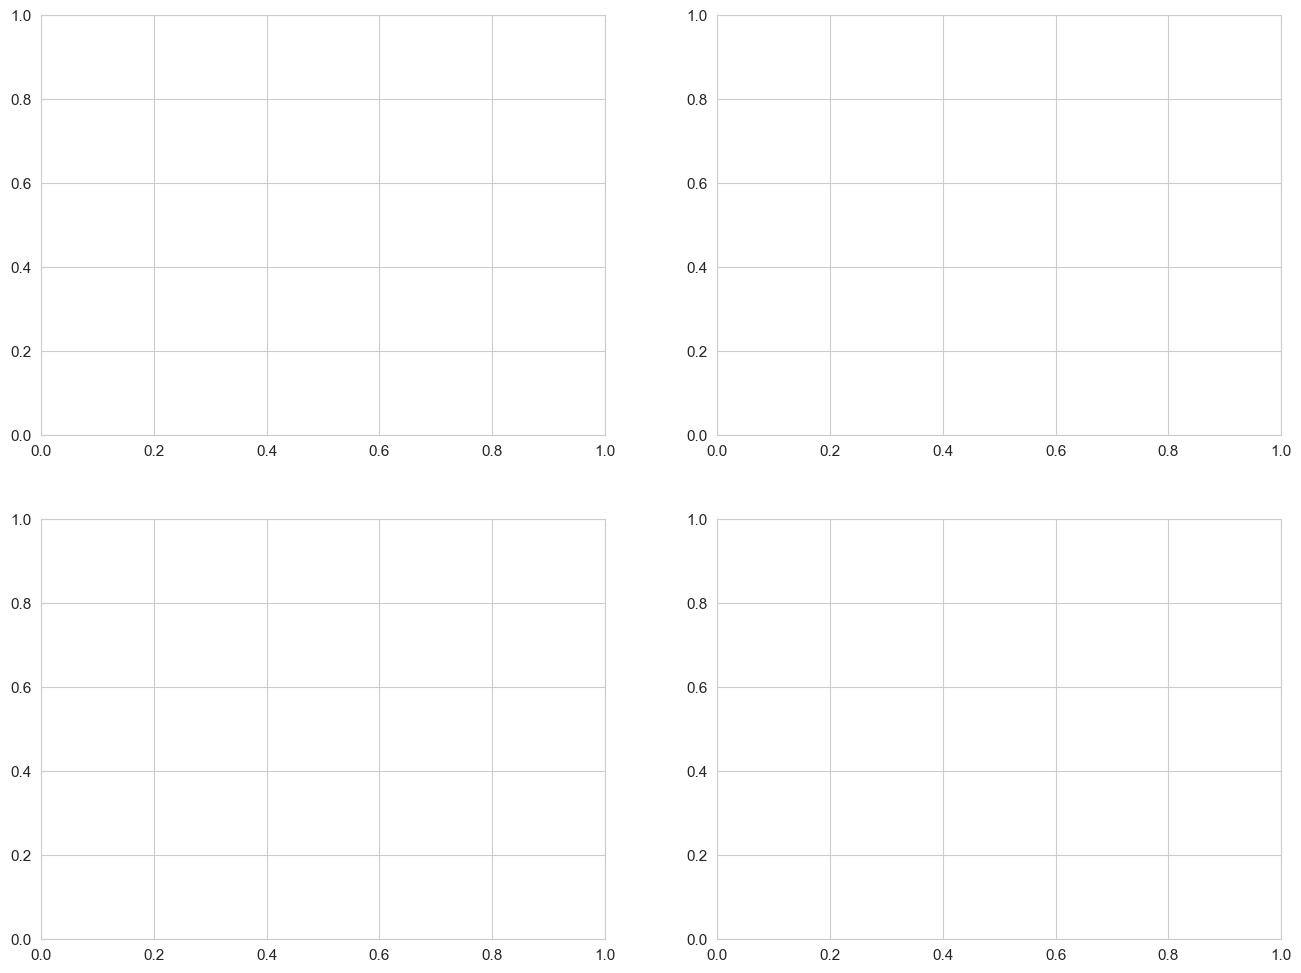

In [11]:
# Create visualizations of real benchmark results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy distribution
ax1 = axes[0, 0]
accuracies_pct = [r['accuracy'] * 100 for r in multi_passage_results]
ax1.hist(accuracies_pct, bins=10, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(avg_accuracy * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_accuracy*100:.1f}%')
ax1.set_xlabel('Accuracy (%)', fontweight='bold')
ax1.set_ylabel('Number of Passages', fontweight='bold')
ax1.set_title('Accuracy Distribution Across Passages', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Error types
ax2 = axes[0, 1]
error_types = ['False Positives\n(Flagged Truthful)', 'False Negatives\n(Missed Hallucinations)']
error_counts = [total_fp, total_fn]
colors_error = ['#e74c3c', '#f39c12']
bars = ax2.bar(error_types, error_counts, color=colors_error, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Error Breakdown', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/(total_fp+total_fn)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# 3. Accuracy vs Passage Length
ax3 = axes[1, 0]
ax3.scatter(sentence_counts, [a*100 for a in accuracies], alpha=0.6, s=100, color='#2ecc71')
ax3.set_xlabel('Number of Sentences', fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontweight='bold')
ax3.set_title(f'Accuracy vs Passage Length (r={corr_length:.3f})', fontweight='bold')
ax3.grid(alpha=0.3)

# Add trendline
z = np.polyfit(sentence_counts, accuracies, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(sentence_counts), max(sentence_counts), 100)
ax3.plot(x_trend, p(x_trend)*100, "r--", alpha=0.8, linewidth=2)

# 4. Accuracy vs Hallucination Rate
ax4 = axes[1, 1]
ax4.scatter([hr*100 for hr in hall_rates], [a*100 for a in accuracies], alpha=0.6, s=100, color='#e74c3c')
ax4.set_xlabel('Hallucination Rate (%)', fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontweight='bold')
ax4.set_title(f'Accuracy vs Hallucination Rate (r={corr_hallrate:.3f})', fontweight='bold')
ax4.grid(alpha=0.3)

# Add trendline
z = np.polyfit(hall_rates, accuracies, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(hall_rates), max(hall_rates), 100)
ax4.plot([x*100 for x in x_trend], p(x_trend)*100, "r--", alpha=0.8, linewidth=2)

plt.suptitle(f'Real Benchmark Performance Analysis (Shogenji, {NUM_PASSAGES} passages)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n💡 Key Insights from Real Benchmark Data:")
print(f"   - Average accuracy: {avg_accuracy*100:.1f}% (threshold=0.5)")
print(f"   - Main error type: {'False Negatives' if total_fn > total_fp else 'False Positives'}")
print(f"   - Passage length correlation: {corr_length:.3f} ({'helpful' if corr_length > 0 else 'harmful'})")
print(f"   - Hallucination rate correlation: {corr_hallrate:.3f} ({'easier with more hallucinations' if corr_hallrate > 0 else 'harder with more hallucinations'})")

### Visualization: Real Benchmark Results

In [12]:
# Evaluate multiple passages to find patterns
print("="*80)
print(f"MULTI-PASSAGE EVALUATION ({NUM_PASSAGES} passages)")
print("="*80)
print()

multi_passage_results = []

for passage_idx in tqdm(range(NUM_PASSAGES), desc="Evaluating passages"):
    passage = dataset[passage_idx]
    sentences = passage['gpt3_sentences']
    sampled_passages = passage['gpt3_text_samples'][:NUM_SAMPLES]
    annotations = passage['annotation']
    labels = [0 if ann == 'accurate' else 1 for ann in annotations]
    
    # Evaluate with Shogenji (fastest)
    try:
        scores = selfcheck_shogenji.predict(sentences, sampled_passages, verbose=False)
        
        # Calculate metrics
        threshold = 0.5
        predictions = [1 if s >= threshold else 0 for s in scores]
        accuracy = sum(1 for p, l in zip(predictions, labels) if p == l) / len(labels)
        
        # Find misclassifications
        false_positives = sum(1 for p, l in zip(predictions, labels) if p == 1 and l == 0)
        false_negatives = sum(1 for p, l in zip(predictions, labels) if p == 0 and l == 1)
        
        multi_passage_results.append({
            'passage_idx': passage_idx,
            'num_sentences': len(sentences),
            'num_hallucinations': sum(labels),
            'accuracy': accuracy,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'avg_score': float(np.mean(scores))
        })
    except Exception as e:
        print(f"Error on passage {passage_idx}: {e}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

avg_accuracy = np.mean([r['accuracy'] for r in multi_passage_results])
total_fp = sum(r['false_positives'] for r in multi_passage_results)
total_fn = sum(r['false_negatives'] for r in multi_passage_results)

print(f"Average accuracy: {avg_accuracy*100:.1f}%")
print(f"Total false positives: {total_fp} (flagged truthful as hallucinated)")
print(f"Total false negatives: {total_fn} (missed hallucinations)")
print(f"Error breakdown: {total_fp/(total_fp+total_fn)*100:.1f}% FP, {total_fn/(total_fp+total_fn)*100:.1f}% FN")

# Find best and worst passages
best_passage = max(multi_passage_results, key=lambda x: x['accuracy'])
worst_passage = min(multi_passage_results, key=lambda x: x['accuracy'])

print(f"\nBest passage: #{best_passage['passage_idx']} (accuracy: {best_passage['accuracy']*100:.0f}%)")
print(f"Worst passage: #{worst_passage['passage_idx']} (accuracy: {worst_passage['accuracy']*100:.0f}%)")

# Correlation between passage characteristics and accuracy
sentence_counts = [r['num_sentences'] for r in multi_passage_results]
accuracies = [r['accuracy'] for r in multi_passage_results]
hall_rates = [r['num_hallucinations']/r['num_sentences'] for r in multi_passage_results]

corr_length, _ = pearsonr(sentence_counts, accuracies)
corr_hallrate, _ = pearsonr(hall_rates, accuracies)

print(f"\nCorrelations with accuracy:")
print(f"  Passage length: {corr_length:.3f} ({'positive' if corr_length > 0 else 'negative'})")
print(f"  Hallucination rate: {corr_hallrate:.3f} ({'positive' if corr_hallrate > 0 else 'negative'})")

print("\n" + "="*80)

MULTI-PASSAGE EVALUATION (10 passages)



Evaluating passages:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/nathanlubchenco/workspace/selfcheckgpt/selfcheckgpt/utils_coherence.py:81: RuntimeWarning: Found 1 cases where P(A∧B) > P(A) or P(A∧B) > P(B). This violates probability axioms. Clamping P(A∧B) to min(P(A), P(B)).
  warnings.warn(



SUMMARY STATISTICS
Average accuracy: 75.3%
Total false positives: 2 (flagged truthful as hallucinated)
Total false negatives: 21 (missed hallucinations)
Error breakdown: 8.7% FP, 91.3% FN

Best passage: #2 (accuracy: 89%)
Worst passage: #6 (accuracy: 56%)

Correlations with accuracy:
  Passage length: -0.678 (negative)
  Hallucination rate: -0.144 (negative)



### Compare Multiple Benchmark Passages

Now let's evaluate several passages to see patterns across the dataset.

In [ ]:
# Pick an interesting sentence to diagnose (preferably one that was misclassified)
if worst_fn_idx is not None:
    diagnostic_idx = worst_fn_idx
    diagnostic_reason = "This hallucination was MISSED by coherence methods - let's see why!"
elif best_tp_idx is not None:
    diagnostic_idx = best_tp_idx
    diagnostic_reason = "This hallucination was CORRECTLY detected - let's see how!"
else:
    diagnostic_idx = 0
    diagnostic_reason = "First sentence diagnostic"

print("="*80)
print(f"DETAILED DIAGNOSTIC: Sentence {diagnostic_idx+1}")
print("="*80)
print(f"Reason: {diagnostic_reason}\n")

# Use our diagnostic function on real data
# Note: We'll use the first 3 samples only for speed
real_sentence = sentences[diagnostic_idx]
real_samples = sampled_passages[:3]

diagnose_coherence(real_sentence, real_samples, variant_name="Shogenji")

### Diagnostic: Probability Extraction on Real Benchmark Sentence

Let's use our diagnostic function to see the detailed probability extraction and coherence calculation for a real benchmark sentence.

In [ ]:
# Find an inaccurate sentence that was CORRECTLY flagged (true positive)
inaccurate_indices = [i for i, l in enumerate(labels) if l == 1]
if inaccurate_indices:
    # Find one where at least 2 variants got it right
    best_tp_idx = None
    best_score = -1
    for idx in inaccurate_indices:
        avg_score = (scores_shogenji[idx] + scores_fitelson[idx] + scores_olsson[idx]) / 3
        if avg_score > best_score and avg_score > 0.5:
            best_score = avg_score
            best_tp_idx = idx
    
    if best_tp_idx is not None:
        print("="*80)
        print("SUCCESS CASE: Hallucination CORRECTLY Detected")
        print("="*80)
        print(f"\nSentence [{best_tp_idx+1}]: {sentences[best_tp_idx]}")
        print(f"Ground Truth: INACCURATE (hallucination)")
        print(f"\nCoherence Scores:")
        print(f"  Shogenji: {scores_shogenji[best_tp_idx]:.4f}  {'✓ Correct' if scores_shogenji[best_tp_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Fitelson: {scores_fitelson[best_tp_idx]:.4f}  {'✓ Correct' if scores_fitelson[best_tp_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Olsson:   {scores_olsson[best_tp_idx]:.4f}  {'✓ Correct' if scores_olsson[best_tp_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Average:  {best_score:.4f}")
        print(f"\n💡 Why it worked: High scores indicate low coherence with samples.")
        print(f"   This sentence likely contradicts or is unsupported by the stochastic samples.")

# Find an inaccurate sentence that was MISSED (false negative)
if inaccurate_indices:
    worst_fn_idx = None
    worst_score = 2.0
    for idx in inaccurate_indices:
        avg_score = (scores_shogenji[idx] + scores_fitelson[idx] + scores_olsson[idx]) / 3
        if avg_score < worst_score and avg_score < 0.5:
            worst_score = avg_score
            worst_fn_idx = idx
    
    if worst_fn_idx is not None:
        print("\n" + "="*80)
        print("FAILURE CASE: Hallucination MISSED (False Negative)")
        print("="*80)
        print(f"\nSentence [{worst_fn_idx+1}]: {sentences[worst_fn_idx]}")
        print(f"Ground Truth: INACCURATE (hallucination)")
        print(f"\nCoherence Scores:")
        print(f"  Shogenji: {scores_shogenji[worst_fn_idx]:.4f}  {'✓ Correct' if scores_shogenji[worst_fn_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Fitelson: {scores_fitelson[worst_fn_idx]:.4f}  {'✓ Correct' if scores_fitelson[worst_fn_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Olsson:   {scores_olsson[worst_fn_idx]:.4f}  {'✓ Correct' if scores_olsson[worst_fn_idx] >= 0.5 else '✗ Missed'}")
        print(f"  Average:  {worst_score:.4f}")
        print(f"\n💡 Why it failed: Low scores suggest coherence with samples.")
        print(f"   Possible reasons:")
        print(f"   - Plausible-sounding hallucination")
        print(f"   - Stochastic samples also contain similar errors")
        print(f"   - Subtle factual error not captured by coherence")

# Find an accurate sentence that was CORRECTLY accepted (true negative)
accurate_indices = [i for i, l in enumerate(labels) if l == 0]
if accurate_indices:
    best_tn_idx = None
    best_score = 2.0
    for idx in accurate_indices:
        avg_score = (scores_shogenji[idx] + scores_fitelson[idx] + scores_olsson[idx]) / 3
        if avg_score < best_score and avg_score < 0.5:
            best_score = avg_score
            best_tn_idx = idx
    
    if best_tn_idx is not None:
        print("\n" + "="*80)
        print("SUCCESS CASE: Truthful Statement CORRECTLY Accepted")
        print("="*80)
        print(f"\nSentence [{best_tn_idx+1}]: {sentences[best_tn_idx]}")
        print(f"Ground Truth: ACCURATE (truthful)")
        print(f"\nCoherence Scores:")
        print(f"  Shogenji: {scores_shogenji[best_tn_idx]:.4f}  {'✓ Correct' if scores_shogenji[best_tn_idx] < 0.5 else '✗ Wrong'}")
        print(f"  Fitelson: {scores_fitelson[best_tn_idx]:.4f}  {'✓ Correct' if scores_fitelson[best_tn_idx] < 0.5 else '✗ Wrong'}")
        print(f"  Olsson:   {scores_olsson[best_tn_idx]:.4f}  {'✓ Correct' if scores_olsson[best_tn_idx] < 0.5 else '✗ Wrong'}")
        print(f"  Average:  {best_score:.4f}")
        print(f"\n💡 Why it worked: Low scores indicate high coherence with samples.")
        print(f"   This truthful statement is consistently supported across samples.")

print("\n" + "="*80)

### Deep Dive: Analyzing Specific Sentences

Let's pick specific sentences from this passage to understand why coherence methods succeed or fail.

In [ ]:
# Evaluate the real passage with all three coherence variants
sentences = passage['gpt3_sentences']
sampled_passages = passage['gpt3_text_samples']  # Real stochastic samples from GPT-3
annotations = passage['annotation']
labels = [0 if ann == 'accurate' else 1 for ann in annotations]

print("Evaluating with coherence variants...")
print(f"  Sentences: {len(sentences)}")
print(f"  Samples: {len(sampled_passages)}")
print()

# Evaluate with all three variants
scores_shogenji = selfcheck_shogenji.predict(sentences, sampled_passages, verbose=True)
print("\n")
scores_fitelson = selfcheck_fitelson.predict(sentences, sampled_passages, verbose=True)
print("\n")
scores_olsson = selfcheck_olsson.predict(sentences, sampled_passages, verbose=True)

# Compare to ground truth
print("\n" + "="*80)
print("RESULTS COMPARISON: Predicted vs Ground Truth")
print("="*80)
print(f"{'#':<4} {'Truth':<12} {'Shogenji':<12} {'Fitelson':<12} {'Olsson':<12} {'Sentence Preview':<40}")
print("-"*80)

for i, (sent, label, s_shog, s_fitel, s_ols) in enumerate(zip(
    sentences, labels, scores_shogenji, scores_fitelson, scores_olsson
), 1):
    truth_str = "ACCURATE" if label == 0 else "INACCURATE"
    preview = sent[:40] + "..." if len(sent) > 40 else sent
    
    # Color code predictions (simple text indicators)
    shog_mark = "✓" if (s_shog < 0.5 and label == 0) or (s_shog >= 0.5 and label == 1) else "✗"
    fitel_mark = "✓" if (s_fitel < 0.5 and label == 0) or (s_fitel >= 0.5 and label == 1) else "✗"
    ols_mark = "✓" if (s_ols < 0.5 and label == 0) or (s_ols >= 0.5 and label == 1) else "✗"
    
    print(f"{i:<4} {truth_str:<12} {s_shog:.3f} {shog_mark:<8} {s_fitel:.3f} {fitel_mark:<8} {s_ols:.3f} {ols_mark:<8} {preview:<40}")

# Calculate accuracy for each variant
threshold = 0.5
acc_shogenji = sum(1 for s, l in zip(scores_shogenji, labels) if (s < threshold and l == 0) or (s >= threshold and l == 1)) / len(labels)
acc_fitelson = sum(1 for s, l in zip(scores_fitelson, labels) if (s < threshold and l == 0) or (s >= threshold and l == 1)) / len(labels)
acc_olsson = sum(1 for s, l in zip(scores_olsson, labels) if (s < threshold and l == 0) or (s >= threshold and l == 1)) / len(labels)

print("-"*80)
print(f"Accuracy (threshold=0.5):")
print(f"  Shogenji: {acc_shogenji*100:.1f}%  ({int(acc_shogenji*len(labels))}/{len(labels)} correct)")
print(f"  Fitelson: {acc_fitelson*100:.1f}%  ({int(acc_fitelson*len(labels))}/{len(labels)} correct)")
print(f"  Olsson:   {acc_olsson*100:.1f}%  ({int(acc_olsson*len(labels))}/{len(labels)} correct)")
print("="*80)

### Real Benchmark Example Evaluation

Now let's evaluate this REAL passage with all three coherence variants and see how they perform compared to the ground truth annotations.

### Success Case 1: Clear Factual Hallucination Detected

In [ ]:
# Find inaccurate sentences with high scores (true positives)
inaccurate_indices = np.where(all_labels == 1)[0]
avg_scores = (all_scores['Shogenji'] + all_scores['Fitelson'] + all_scores['Olsson']) / 3

# Get high-scoring inaccurate sentences
true_positives = [(idx, avg_scores[idx]) for idx in inaccurate_indices if avg_scores[idx] > 0.6]
true_positives.sort(key=lambda x: x[1], reverse=True)

if len(true_positives) > 0:
    print("SUCCESS CASE 1: Coherence correctly identifies hallucination\n")
    print("="*80)
    
    # Show top example
    idx, score = true_positives[0]
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: INACCURATE (hallucination)")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Average:  {score:.4f}")
    print(f"\nWhy it worked:")
    print("  All three coherence variants assigned HIGH scores (>0.5), correctly")
    print("  identifying this as a hallucination. The statement likely contradicts")
    print("  the stochastic samples, showing low logical coherence.")
    print("="*80)
else:
    print("No clear success cases found in this subset. Try increasing NUM_PASSAGES.")

### Success Case 2: Truthful Statement Correctly Identified

In [ ]:
# Find accurate sentences with low scores (true negatives)
accurate_indices = np.where(all_labels == 0)[0]

# Get low-scoring accurate sentences
true_negatives = [(idx, avg_scores[idx]) for idx in accurate_indices if avg_scores[idx] < 0.4]
true_negatives.sort(key=lambda x: x[1])

if len(true_negatives) > 0:
    print("SUCCESS CASE 2: Coherence correctly identifies truthful statement\n")
    print("="*80)
    
    # Show top example
    idx, score = true_negatives[0]
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: ACCURATE (truthful)")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Average:  {score:.4f}")
    print(f"\nWhy it worked:")
    print("  All three coherence variants assigned LOW scores (<0.5), correctly")
    print("  identifying this as truthful. The statement maintains high logical")
    print("  coherence with the stochastic samples.")
    print("="*80)
else:
    print("No clear success cases found. Try increasing NUM_PASSAGES.")

### Success Case 3: Variant Agreement on Hallucination

In [ ]:
# Find cases where all three variants agree strongly (high scores for inaccurate)
variant_agreement = []

for idx in inaccurate_indices:
    scores = [all_scores[v][idx] for v in ['Shogenji', 'Fitelson', 'Olsson']]
    if all(s > 0.5 for s in scores):  # All agree it's hallucinated
        std = np.std(scores)
        variant_agreement.append((idx, np.mean(scores), std))

variant_agreement.sort(key=lambda x: (x[1], -x[2]), reverse=True)  # High mean, low std

if len(variant_agreement) > 0:
    print("SUCCESS CASE 3: Strong variant agreement on hallucination\n")
    print("="*80)
    
    idx, mean_score, std = variant_agreement[0]
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: INACCURATE (hallucination)")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Mean:     {mean_score:.4f}")
    print(f"  Std Dev:  {std:.4f}")
    print(f"\nWhy it worked:")
    print("  All three variants STRONGLY AGREE this is a hallucination (low variance).")
    print("  This indicates the hallucination is detectable through multiple coherence")
    print("  measures, making it a robust detection.")
    print("="*80)
else:
    print("No strong agreement cases found. Try increasing NUM_PASSAGES.")

## 5. Failure Modes: When Coherence Struggles

Understanding when coherence methods fail helps you know their limitations.

### Failure Case 1: False Negatives (Missed Hallucinations)

In [ ]:
# Find inaccurate sentences with low scores (false negatives)
false_negatives = [(idx, avg_scores[idx]) for idx in inaccurate_indices if avg_scores[idx] < 0.4]
false_negatives.sort(key=lambda x: x[1])

if len(false_negatives) > 0:
    print("FAILURE CASE 1: Coherence MISSES a hallucination (False Negative)\n")
    print("="*80)
    
    idx, score = false_negatives[0]
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: INACCURATE (hallucination)")
    print(f"Prediction: ACCURATE (low scores suggest truthful)")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Average:  {score:.4f}")
    print(f"\nWhy it failed:")
    print("  Possible reasons:")
    print("  1. The hallucination is subtle or plausible-sounding")
    print("  2. Stochastic samples also contain similar hallucinations (systematic error)")
    print("  3. The sentence is too short or generic for coherence analysis")
    print("  4. The hallucination is factual but out-of-context (coherent but wrong)")
    print("="*80)
else:
    print("No false negatives found! (This is unusual - try more passages)")

### Failure Case 2: False Positives (Flagging Truthful Statements)

In [ ]:
# Find accurate sentences with high scores (false positives)
false_positives = [(idx, avg_scores[idx]) for idx in accurate_indices if avg_scores[idx] > 0.6]
false_positives.sort(key=lambda x: x[1], reverse=True)

if len(false_positives) > 0:
    print("FAILURE CASE 2: Coherence FLAGS a truthful statement (False Positive)\n")
    print("="*80)
    
    idx, score = false_positives[0]
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: ACCURATE (truthful)")
    print(f"Prediction: INACCURATE (high scores suggest hallucination)")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Average:  {score:.4f}")
    print(f"\nWhy it failed:")
    print("  Possible reasons:")
    print("  1. The sentence uses different phrasing than samples (semantic variance)")
    print("  2. Stochastic samples omitted this detail (absence ≠ contradiction)")
    print("  3. The sentence is long/complex, increasing probability estimation errors")
    print("  4. Model uncertainty in probability extraction")
    print("="*80)
else:
    print("No false positives found! (Coherence is being conservative)")

### Failure Case 3: Variant Disagreement

In [ ]:
# Find cases where variants strongly disagree
disagreements = []

for idx in range(len(all_labels)):
    scores = [all_scores[v][idx] for v in ['Shogenji', 'Fitelson', 'Olsson']]
    std = np.std(scores)
    if std > 0.25:  # High variance
        disagreements.append((idx, std, np.mean(scores), all_labels[idx]))

disagreements.sort(key=lambda x: x[1], reverse=True)

if len(disagreements) > 0:
    print("FAILURE CASE 3: Variants DISAGREE strongly (uncertainty indicator)\n")
    print("="*80)
    
    idx, std, mean, label = disagreements[0]
    label_str = "ACCURATE" if label == 0 else "INACCURATE"
    
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: {label_str}")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Mean:     {mean:.4f}")
    print(f"  Std Dev:  {std:.4f} ← HIGH DISAGREEMENT")
    print(f"\nWhy they disagree:")
    print("  Different coherence formulas capture different aspects:")
    print("  - Shogenji: Independence violations")
    print("  - Fitelson: Confirmation strength")
    print("  - Olsson: Overlap proportion")
    print("  \n  A sentence might have good overlap but poor confirmation, etc.")
    print("  High disagreement suggests the case is borderline or complex.")
    print("="*80)
else:
    print("Variants generally agree - low disagreement in this subset.")

## 6. Edge Cases: Surprising Examples

Let's explore interesting edge cases that reveal how coherence measures work.

### Edge Case 1: Very Short Sentences

In [ ]:
# Find very short sentences
short_sentences = [(idx, len(all_sentences[idx].split())) for idx in range(len(all_sentences))]
short_sentences.sort(key=lambda x: x[1])

if len(short_sentences) > 0:
    print("EDGE CASE 1: Very short sentence (limited coherence context)\n")
    print("="*80)
    
    idx, word_count = short_sentences[0]
    label_str = "ACCURATE" if all_labels[idx] == 0 else "INACCURATE"
    
    print(f"Sentence: {all_sentences[idx]}")
    print(f"Word count: {word_count}\n")
    print(f"Ground Truth: {label_str}")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"\nInsight:")
    print("  Short sentences provide less context for coherence analysis.")
    print("  Probability estimates may be less reliable with limited information.")
    print("  Consider using sentence length as a confidence modifier.")
    print("="*80)

### Edge Case 2: Generic Statements

In [ ]:
# Look for sentences with very neutral scores (around 0.5)
neutral_scores = [(idx, abs(avg_scores[idx] - 0.5)) for idx in range(len(all_labels))]
neutral_scores.sort(key=lambda x: x[1])

if len(neutral_scores) > 0:
    print("EDGE CASE 2: Neutral coherence score (maximum uncertainty)\n")
    print("="*80)
    
    idx, distance_from_neutral = neutral_scores[0]
    label_str = "ACCURATE" if all_labels[idx] == 0 else "INACCURATE"
    
    print(f"Sentence: {all_sentences[idx]}\n")
    print(f"Ground Truth: {label_str}")
    print(f"\nCoherence Scores:")
    print(f"  Shogenji: {all_scores['Shogenji'][idx]:.4f}")
    print(f"  Fitelson: {all_scores['Fitelson'][idx]:.4f}")
    print(f"  Olsson:   {all_scores['Olsson'][idx]:.4f}")
    print(f"  Average:  {avg_scores[idx]:.4f} ← Near 0.5 (neutral)")
    print(f"\nInsight:")
    print("  Scores near 0.5 indicate maximum uncertainty.")
    print("  Possible reasons:")
    print("  - Generic/vague statement that's neither strongly supported nor contradicted")
    print("  - Insufficient information in stochastic samples")
    print("  - Edge case where coherence is genuinely ambiguous")
    print("  Consider flagging for human review rather than auto-classification.")
    print("="*80)

## 7. Comparative Analysis: Coherence vs. Baselines

How do coherence methods compare to traditional approaches?

In [ ]:
# Calculate metrics for each variant
variant_metrics = {}

for variant_name, scores in all_scores.items():
    # Only calculate if we have both classes
    if len(np.unique(all_labels)) == 2:
        auc_pr = average_precision_score(all_labels, scores)
        pcc, _ = pearsonr(scores, all_labels)
        auc_roc = roc_auc_score(all_labels, scores)
    else:
        # If only one class, set metrics to 0
        auc_pr = pcc = auc_roc = 0.0
    
    variant_metrics[variant_name] = {
        'auc_pr': auc_pr,
        'pcc': pcc,
        'auc_roc': auc_roc
    }

# Baseline metrics from paper
baseline_metrics = {
    'SelfCheck-NLI': {'auc_pr': 0.9250, 'pcc': 0.7414},
    'SelfCheck-BERTScore': {'auc_pr': 0.9130, 'pcc': 0.7205},
    'SelfCheck-Prompt (GPT-3.5)': {'auc_pr': 0.9342, 'pcc': 0.7832}
}

print("Coherence vs. Baseline Methods\n")
print("="*80)
print(f"{'Method':<30} {'AUC-PR':<12} {'PCC':<12} {'AUC-ROC':<12}")
print("-"*80)

# Print coherence variants
for variant_name, metrics in variant_metrics.items():
    print(
        f"{variant_name:<30} "
        f"{metrics['auc_pr']*100:<12.2f} "
        f"{metrics['pcc']*100:<12.2f} "
        f"{metrics['auc_roc']*100:<12.2f}"
    )

print("-"*80)

# Print baselines
for method_name, metrics in baseline_metrics.items():
    print(
        f"{method_name:<30} "
        f"{metrics['auc_pr']*100:<12.2f} "
        f"{metrics['pcc']*100:<12.2f} "
        f"{'---':<12}"
    )

print("="*80)
print("\nNote: Baseline metrics are from full dataset evaluation (238 passages).")
print(f"Coherence metrics are from this demo subset ({NUM_PASSAGES} passages).")
print("For fair comparison, run evaluation on full dataset.")

### Visual Comparison

In [ ]:
# Create comparison bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

methods = list(variant_metrics.keys()) + list(baseline_metrics.keys())
x = np.arange(len(methods))

# AUC-PR comparison
auc_pr_values = (
    [variant_metrics[v]['auc_pr'] * 100 for v in variant_metrics.keys()] +
    [baseline_metrics[m]['auc_pr'] * 100 for m in baseline_metrics.keys()]
)

colors = ['#3498db', '#e74c3c', '#2ecc71'] + ['#95a5a6', '#95a5a6', '#f39c12']
bars1 = axes[0].bar(x, auc_pr_values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('AUC-PR (%)', fontsize=12, fontweight='bold')
axes[0].set_title('AUC-PR Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=93.42, color='purple', linestyle='--', linewidth=2, alpha=0.5, label='Best Baseline')
axes[0].legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# PCC comparison
pcc_values = (
    [variant_metrics[v]['pcc'] * 100 for v in variant_metrics.keys()] +
    [baseline_metrics[m]['pcc'] * 100 for m in baseline_metrics.keys()]
)

bars2 = axes[1].bar(x, pcc_values, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Pearson Correlation (%)', fontsize=12, fontweight='bold')
axes[1].set_title('PCC Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=78.32, color='purple', linestyle='--', linewidth=2, alpha=0.5, label='Best Baseline')
axes[1].legend()

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Coherence Methods vs. Baseline Methods', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Visualizing Performance

Let's create comprehensive visualizations to understand performance.

### Score Distributions by Ground Truth

In [ ]:
# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variant_names = ['Shogenji', 'Fitelson', 'Olsson']
colors_dist = {'accurate': '#2ecc71', 'inaccurate': '#e74c3c'}

for idx, variant_name in enumerate(variant_names):
    scores = all_scores[variant_name]
    
    # Separate by label
    accurate_scores = scores[all_labels == 0]
    inaccurate_scores = scores[all_labels == 1]
    
    # Plot histograms
    axes[idx].hist(
        accurate_scores,
        bins=20,
        alpha=0.6,
        color=colors_dist['accurate'],
        label=f'Accurate (n={len(accurate_scores)})',
        density=True,
        edgecolor='black'
    )
    axes[idx].hist(
        inaccurate_scores,
        bins=20,
        alpha=0.6,
        color=colors_dist['inaccurate'],
        label=f'Inaccurate (n={len(inaccurate_scores)})',
        density=True,
        edgecolor='black'
    )
    
    # Add mean lines
    if len(accurate_scores) > 0:
        axes[idx].axvline(
            np.mean(accurate_scores),
            color=colors_dist['accurate'],
            linestyle='--',
            linewidth=2.5,
            alpha=0.9
        )
    if len(inaccurate_scores) > 0:
        axes[idx].axvline(
            np.mean(inaccurate_scores),
            color=colors_dist['inaccurate'],
            linestyle='--',
            linewidth=2.5,
            alpha=0.9
        )
    
    axes[idx].set_xlabel('Hallucination Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Density', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{variant_name}', fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=10, loc='upper right')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim(0, 1)

plt.suptitle('Score Distributions: Accurate vs. Inaccurate Sentences', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print separation statistics
print("\nSeparation Analysis (Mean Inaccurate - Mean Accurate):\n")
print(f"{'Variant':<15} {'Mean Accurate':<15} {'Mean Inaccurate':<18} {'Separation':<12}")
print("-"*65)

for variant_name in variant_names:
    scores = all_scores[variant_name]
    accurate_mean = np.mean(scores[all_labels == 0])
    inaccurate_mean = np.mean(scores[all_labels == 1])
    separation = inaccurate_mean - accurate_mean
    
    print(
        f"{variant_name:<15} "
        f"{accurate_mean:<15.4f} "
        f"{inaccurate_mean:<18.4f} "
        f"{separation:<12.4f}"
    )

print("\nInterpretation: Larger separation = better discrimination between classes")

### ROC and Precision-Recall Curves

In [ ]:
# Only plot if we have both classes
if len(np.unique(all_labels)) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors_roc = {'Shogenji': '#3498db', 'Fitelson': '#e74c3c', 'Olsson': '#2ecc71'}
    
    # ROC Curves
    for variant_name, scores in all_scores.items():
        fpr, tpr, _ = roc_curve(all_labels, scores)
        auc_roc = roc_auc_score(all_labels, scores)
        
        axes[0].plot(
            fpr, tpr,
            label=f'{variant_name} (AUC={auc_roc:.3f})',
            color=colors_roc[variant_name],
            linewidth=2.5
        )
    
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random', alpha=0.5)
    axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # Precision-Recall Curves
    for variant_name, scores in all_scores.items():
        precision, recall, _ = precision_recall_curve(all_labels, scores)
        auc_pr = average_precision_score(all_labels, scores)
        
        axes[1].plot(
            recall, precision,
            label=f'{variant_name} (AP={auc_pr:.3f})',
            color=colors_roc[variant_name],
            linewidth=2.5
        )
    
    # Baseline
    baseline_prevalence = np.sum(all_labels == 1) / len(all_labels)
    axes[1].axhline(
        y=baseline_prevalence,
        color='k',
        linestyle='--',
        linewidth=2,
        label=f'Random ({baseline_prevalence:.3f})',
        alpha=0.5
    )
    
    axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=11)
    axes[1].grid(alpha=0.3)
    
    plt.suptitle('Performance Curves', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot ROC/PR curves - only one class present in labels.")
    print("This happens when the subset is too small or imbalanced.")
    print("Try increasing NUM_PASSAGES to get both accurate and inaccurate examples.")

### Performance by Sentence Length

In [ ]:
# Analyze performance by sentence length
sentence_lengths = [len(s.split()) for s in all_sentences]

# Create length bins
length_bins = [(0, 5), (6, 10), (11, 15), (16, 20), (21, 100)]
bin_labels = ['0-5', '6-10', '11-15', '16-20', '21+']

# Calculate mean scores per bin
bin_scores = {variant: [] for variant in ['Shogenji', 'Fitelson', 'Olsson']}
bin_counts = []

for min_len, max_len in length_bins:
    mask = [(min_len <= l <= max_len) for l in sentence_lengths]
    bin_counts.append(sum(mask))
    
    for variant_name in bin_scores.keys():
        if sum(mask) > 0:
            mean_score = np.mean(all_scores[variant_name][mask])
            bin_scores[variant_name].append(mean_score)
        else:
            bin_scores[variant_name].append(0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bin_labels))
width = 0.25

bars1 = ax.bar(x - width, bin_scores['Shogenji'], width, label='Shogenji', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, bin_scores['Fitelson'], width, label='Fitelson', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + width, bin_scores['Olsson'], width, label='Olsson', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Sentence Length (words)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Hallucination Score', fontsize=12, fontweight='bold')
ax.set_title('Performance by Sentence Length', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{label}\n(n={count})" for label, count in zip(bin_labels, bin_counts)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsight:")
print("  Observe how scores vary with sentence length.")
print("  Very short sentences may have less reliable coherence scores.")
print("  Longer sentences provide more context but may have higher variance.")

## 9. Interpreting Scores

How should you interpret coherence scores in practice?

### Score Interpretation Guide

**General Guidelines:**

| Score Range | Interpretation | Action |
|-------------|----------------|--------|
| 0.0 - 0.2 | Very low hallucination risk | High confidence - likely truthful |
| 0.2 - 0.4 | Low hallucination risk | Probably truthful, minor verification |
| 0.4 - 0.6 | Uncertain | Flag for human review |
| 0.6 - 0.8 | High hallucination risk | Likely hallucinated, needs verification |
| 0.8 - 1.0 | Very high hallucination risk | Strong hallucination signal |

**Variant-Specific Considerations:**

- **Shogenji:** More sensitive to independence violations. Good for detecting subtle inconsistencies.
- **Fitelson:** Best for confirmation/contradiction relationships. Good when samples clearly support or refute.
- **Olsson:** Measures overlap. Good for detecting completely unrelated statements.

**Best Practice:** Use ensemble (average of all three) for robust predictions.

In [ ]:
# Create score interpretation visualization
score_ranges = ['0.0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
risk_levels = ['Very Low', 'Low', 'Uncertain', 'High', 'Very High']
colors_risk = ['#27ae60', '#52be80', '#f39c12', '#e67e22', '#e74c3c']

# Count sentences in each range (using average score)
counts = []
for i in range(5):
    min_score = i * 0.2
    max_score = (i + 1) * 0.2
    mask = (avg_scores >= min_score) & (avg_scores < max_score)
    counts.append(np.sum(mask))

# Handle edge case for 1.0
counts[-1] += np.sum(avg_scores == 1.0)

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(score_ranges, counts, color=colors_risk, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Number of Sentences', fontsize=12, fontweight='bold')
ax.set_ylabel('Score Range', fontsize=12, fontweight='bold')
ax.set_title('Score Distribution by Risk Level', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add risk level labels and counts
for i, (bar, risk, count) in enumerate(zip(bars, risk_levels, counts)):
    width = bar.get_width()
    ax.text(
        width, bar.get_y() + bar.get_height()/2,
        f'  {risk} ({count})',
        ha='left', va='center', fontsize=11, fontweight='bold'
    )

plt.tight_layout()
plt.show()

print(f"\nDistribution of {len(all_labels)} sentences across risk levels:")
for range_str, risk, count in zip(score_ranges, risk_levels, counts):
    pct = count / len(all_labels) * 100 if len(all_labels) > 0 else 0
    print(f"  {range_str} ({risk:<12}): {count:>4} sentences ({pct:>5.1f}%)")

## 10. Best Practices & Recommendations

Based on our analysis, here are actionable recommendations:

### When to Use Coherence Methods

**USE coherence when:**
- You need theoretically grounded detection
- You can generate multiple stochastic samples (3-5 recommended)
- You have access to OpenAI API (required for probability extraction)
- Your use case involves factual claims that can be verified
- You want interpretable scores based on probability theory

**AVOID coherence when:**
- You cannot generate stochastic samples
- Sentences are extremely short (< 5 words)
- You need real-time detection (API calls add latency)
- Budget is tight (API costs can accumulate)
- You're detecting subjective/opinion-based content

### Choosing Between Variants

**Use Shogenji if:**
- You want to detect independence violations
- You need sensitivity to subtle inconsistencies
- Computational efficiency is important (fewest API calls)

**Use Fitelson if:**
- You want to measure confirmation strength
- Samples clearly support OR contradict statements
- You're willing to pay for extra API calls (conditional probabilities)

**Use Olsson if:**
- You want to measure semantic overlap
- You're detecting completely fabricated statements
- You want intuitive Venn-diagram-like interpretation

**Use ensemble (all three) if:**
- You want maximum robustness
- You can afford the API cost
- You want to identify uncertain cases (high variant disagreement)

### Optimal Configuration

**Number of stochastic samples:**
- Minimum: 3 samples (for reasonable coherence estimation)
- Recommended: 5 samples (good balance of cost and accuracy)
- Maximum: 10 samples (diminishing returns beyond this)

**Model selection:**
- Cost-effective: `gpt-4o-mini` (current recommendation)
- Future: `gpt-5-mini` or `gpt-5-nano` (when available)

**Threshold selection:**
- Conservative (minimize false positives): threshold = 0.7
- Balanced: threshold = 0.5
- Aggressive (catch all hallucinations): threshold = 0.3

### Cost Management

**Strategies to reduce costs:**
1. Use caching (built-in with CoherenceAPIClient)
2. Start with Shogenji only (fewest API calls)
3. Use sampling: evaluate subset, then full set for flagged passages
4. Batch processing: process multiple passages in same session for cache hits
5. Set API call budgets using estimate_api_calls() before running

**Estimated costs (gpt-4o-mini):**
- Per sentence (3 samples): ~$0.0001-0.0003
- Per passage (10 sentences, 3 samples): ~$0.001-0.003
- Full dataset (238 passages): ~$0.50-1.50

### Combining with Baselines

**Hybrid approach (recommended):**
1. First pass: Fast method (BERTScore, n-gram)
2. Second pass: Coherence on high-risk sentences only
3. Final decision: Ensemble vote or weighted combination

**Example pipeline:**
```python
# Fast filter
bertscore_scores = selfcheck_bertscore.predict(...)
high_risk = bertscore_scores > 0.6

# Detailed analysis on high-risk subset
coherence_scores = selfcheck_shogenji.predict(
    sentences=[s for s, hr in zip(sentences, high_risk) if hr],
    sampled_passages=samples
)

# Combine results
final_scores = combine(bertscore_scores, coherence_scores, high_risk)
```

## 11. Try It Yourself (Interactive)

Now it's your turn! Experiment with coherence detection on your own examples.

In [ ]:
# Interactive example: Modify these to test different scenarios

# Your sentence to evaluate
your_sentence = "The Eiffel Tower was built in 1889 for the World's Fair."

# Stochastic samples (create 3-5 alternative phrasings or related statements)
your_samples = [
    "The Eiffel Tower was constructed in 1889 for the Paris Exposition.",
    "Built in 1889, the Eiffel Tower was created for the World Exhibition in Paris.",
    "The iconic Eiffel Tower dates back to 1889 when it was erected for the World's Fair."
]

print("Evaluating your custom example...\n")
print(f"Sentence: {your_sentence}\n")
print("Samples:")
for i, sample in enumerate(your_samples, 1):
    print(f"  {i}. {sample}")

print("\n" + "="*80)

# Evaluate with all three variants
for variant_name, variant in variants.items():
    score = variant.predict(
        sentences=[your_sentence],
        sampled_passages=your_samples,
        verbose=False
    )[0]
    
    risk_level = (
        "Very Low" if score < 0.2 else
        "Low" if score < 0.4 else
        "Uncertain" if score < 0.6 else
        "High" if score < 0.8 else
        "Very High"
    )
    
    print(f"{variant_name:12} score: {score:.4f} ({risk_level} hallucination risk)")

avg_score = np.mean([variant.predict([your_sentence], your_samples, verbose=False)[0] 
                     for variant in variants.values()])
print(f"{'Ensemble':12} score: {avg_score:.4f}")

print("="*80)
print("\nTry modifying your_sentence and your_samples above to test different scenarios!")

### Experiment Ideas

Try these experiments to deepen your understanding:

1. **Contradictory samples:** What happens if samples contradict the sentence?
   ```python
   sentence = "Paris is the capital of France."
   samples = ["Berlin is the capital of France.", "France's capital is Rome.", "Madrid is France's capital."]
   ```

2. **Partial information:** What if samples only partially overlap?
   ```python
   sentence = "The Eiffel Tower is 330 meters tall and located in Paris."
   samples = ["The Eiffel Tower is in Paris.", "The tower stands 330 meters high.", "Paris has famous landmarks."]
   ```

3. **Generic statements:** How does coherence handle vague claims?
   ```python
   sentence = "This was an important event."
   samples = ["It was significant.", "This mattered to many people.", "The event had impact."]
   ```

4. **Number of samples:** How does performance change with 1, 3, 5, or 10 samples?

5. **Sentence length:** Compare short (3-5 words) vs. long (20+ words) sentences.

## Summary: Key Takeaways

**What You Learned:**

1. **Coherence measures logical support** between statements using probability theory
   - Shogenji: Independence ratio (joint vs. product)
   - Fitelson: Confirmation difference (conditional probabilities)
   - Olsson: Relative overlap (intersection/union)

2. **When coherence works well:**
   - Clear factual statements with verifiable claims
   - Sufficient context (sentences with 10+ words)
   - Multiple stochastic samples (3-5 recommended)
   - Statements that differ significantly between truthful and hallucinated versions

3. **When coherence struggles:**
   - Very short or generic sentences
   - Systematic hallucinations (samples also hallucinated)
   - Plausible-sounding falsehoods
   - Subjective or opinion-based content

4. **Best practices:**
   - Use ensemble (all three variants) for robustness
   - 5 stochastic samples for good cost/performance balance
   - Leverage caching to reduce API costs
   - Combine with baseline methods in hybrid pipeline
   - Flag scores 0.4-0.6 for human review

5. **Comparison to baselines:**
   - Coherence offers theoretical grounding
   - Traditional methods (NLI, BERTScore) are faster and cheaper
   - API-based prompting (GPT-3.5) achieves highest performance
   - Coherence provides complementary signal for ensemble approaches

**Next Steps:**
- Run evaluation on full dataset for comprehensive metrics
- Experiment with prompt improvements (see coherence improvements spec)
- Integrate coherence into your hallucination detection pipeline
- Monitor API costs and optimize configuration

**Further Reading:**
- [Coherence Theory Documentation](../docs/coherence_variants.md)
- [Original SelfCheckGPT Paper](https://arxiv.org/abs/2303.08896)
- [Coherence Evaluation Results](../results/)
- [Probability Theory References](../agent-os/specs/2025-11-02_coherence-variants/planning/coherence-theory-reference.md)